In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.bopdmd import BOPDMD
from pydmd import DMDc
from scipy.signal import StateSpace, lsim, dlsim
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import scipy
from pydmd.plotter import plot_eigs
from sklearn.preprocessing import StandardScaler

In [2]:
# Define the state space model parameters
Amplitude = 600
Amplitude1 = 600
Frequency = 19000  # injector frequency
RunTime = .004
SampleTime = 1e-7 
L1 = 8.0141e-7 # H
L2 = 2.0462e-6 # H
M = .161 * L2  # Coupling coefficient
Mw = .1346 * L2  # Coupling coefficient
Cap = 96e-6  # F
R1 = .0025  # Ohm
R2 = .005  # Ohm
R3 = .005  # Ohm
dT = 1e-7
PhaseAngle1 = 90
PhaseAngle2 = 180
PhaseAngle3 = 270

# Scale factor in front of the entries to the A matrix 
# that are affected by mutual inductance
scalar1 = 1 / ((L2 - Mw) * ( (L2 ** 2) - (4 * M ** 2)  +  2 *L2 * Mw +  (Mw ** 2) ))
x3a =  (-L2 ** 2) * R2 + (2 * M ** 2) * R2 -L2 * Mw * R2
x3b = (-L2 ** 2) + (2 * M ** 2)-L2 * Mw
x3c = (L2 ** 2) * R2 - (2 * M ** 2) * R2 + L2 * Mw * R2 + (L2 ** 2) * R3 - (2 * M ** 2) * R3 + L2 * Mw * R3
x3d = L2 * M * R2 - M * Mw * R2
x3e = L2 * M- M * Mw
x3f = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3g = L2 * M * R2 - M * Mw * R2
x3h = L2 * M- M * Mw
x3i = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3j = - 2 * (M ** 2) * R2 + L2 * Mw * R2 + (Mw ** 2) * R2
x3k = - 2 * (M ** 2) + L2 * Mw + Mw ** 2
x3l = 2 * (M ** 2) * R2 -L2 * Mw * R2 - (Mw ** 2) * R2 + 2 * R3 * (M ** 2)-L2 * Mw * R3 - R3 * Mw ** 2

# Entries for x6 in A matrix
x6a = -L2 * M * R2 + M * Mw * R2
x6b = -L2 * M + M * Mw
x6c = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3
x6d = R2 * (L2 ** 2)- 2 * R2 * (M ** 2) + L2 * Mw * R2
x6e = (L2 ** 2)- 2 * (M ** 2) + L2 * Mw
x6f = - R2 * (L2 ** 2) + 2 * R2 * (M ** 2)-L2 * Mw * R2 - R3 * (L2 ** 2) + 2 * R3 * (M ** 2)-L2 * Mw * R3
x6g = 2 * R2 * (M ** 2)-L2 * Mw * R2 - R2 * (Mw ** 2)
x6h = 2 * (M ** 2)-L2 * Mw- (Mw ** 2)
x6i = - 2 * R2 * (M ** 2) + L2 * Mw * R2 + R2 * (Mw ** 2)- 2 * R3 * (M ** 2) + L2 * Mw * R3 + R3 * (Mw ** 2)
x6j = -L2 * M * R2 + M * Mw * R2
x6k = -L2 * M + M * Mw
x6l = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3

# Entries for x9 in A matrix
x9a = -L2 * M * R2  +  M * Mw * R2
x9b = -L2 * M  +  M * Mw
x9c = L2 * M * R2 - M * Mw * R2 *  +  L2 * M * R3  - M * Mw * R3
x9d = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2
x9e = 2 * (M ** 2) - L2 * Mw - (Mw ** 2)
x9f = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  +  (Mw ** 2) * R2 - 2 * (M ** 2) * R3  +  L2 * Mw * R3  +  (Mw ** 2) * R3
x9g =(L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2
x9h = (L2 ** 2) - 2 * (M ** 2)  +  L2 * Mw
x9i = - (L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2 - (L2 ** 2) * R3  +  2 * (M ** 2) * R3 - L2 * Mw * R3
x9j = -L2 * M * R2  +  M * Mw * R2
x9k = -L2 * M  +  M * Mw 
x9l = L2 * M * R2 - M * Mw * R2  +  L2 * M * R3 - M * Mw * R3

#Entries for x12 in A matrix
x12a = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  + (Mw ** 2) * R2
x12b = - 2 * (M ** 2)  +  L2 * Mw  +  (Mw ** 2)
x12c = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2  +  2 * (M ** 2) * R3 - L2 * Mw * R3 - (Mw ** 2) * R3
x12d = L2 * M * R2 - M * Mw * R2
x12e = L2 * M - M * Mw
x12f = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12g = L2 * M * R2 - M * Mw * R2
x12h = L2 * M - M * Mw
x12i = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12j = (-L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2
x12k = (-L2 ** 2)  +  2 * (M ** 2) - L2 * Mw
x12l = (L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2  +  (L2 ** 2) * R3 - 2 * (M ** 2) * R3  +  L2 * Mw * R3

In [3]:
# Define the state space model parameters
Amplitude = 600
Amplitude1 = 600
Frequency = 19000  # injector frequency
RunTime = .004
SampleTime = 1e-7 
L1 = 8.0141e-7 # H
L2 = 2.0462e-6 # H
M = .161 * L2  # Coupling coefficient
Mw = .1346 * L2  # Coupling coefficient
Cap = 96e-6  # F
R1 = .0025  # Ohm
R2 = .005  # Ohm
R3 = .005  # Ohm
dT = 1e-7
PhaseAngle1 = 90
PhaseAngle2 = 180
PhaseAngle3 = 270

# Scale factor in front of the entries to the A matrix 
# that are affected by mutual inductance
scalar1 = 1 / ((L2 - Mw) * ( (L2 ** 2) - (4 * M ** 2)  +  2 *L2 * Mw +  (Mw ** 2) ))
x3a =  (-L2 ** 2) * R2 + (2 * M ** 2) * R2 -L2 * Mw * R2
x3b = (-L2 ** 2) + (2 * M ** 2)-L2 * Mw
x3c = (L2 ** 2) * R2 - (2 * M ** 2) * R2 + L2 * Mw * R2 + (L2 ** 2) * R3 - (2 * M ** 2) * R3 + L2 * Mw * R3
x3d = L2 * M * R2 - M * Mw * R2
x3e = L2 * M- M * Mw
x3f = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3g = L2 * M * R2 - M * Mw * R2
x3h = L2 * M- M * Mw
x3i = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3j = - 2 * (M ** 2) * R2 + L2 * Mw * R2 + (Mw ** 2) * R2
x3k = - 2 * (M ** 2) + L2 * Mw + Mw ** 2
x3l = 2 * (M ** 2) * R2 -L2 * Mw * R2 - (Mw ** 2) * R2 + 2 * R3 * (M ** 2)-L2 * Mw * R3 - R3 * Mw ** 2

# Entries for x6 in A matrix
x6a = -L2 * M * R2 + M * Mw * R2
x6b = -L2 * M + M * Mw
x6c = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3
x6d = R2 * (L2 ** 2)- 2 * R2 * (M ** 2) + L2 * Mw * R2
x6e = (L2 ** 2)- 2 * (M ** 2) + L2 * Mw
x6f = - R2 * (L2 ** 2) + 2 * R2 * (M ** 2)-L2 * Mw * R2 - R3 * (L2 ** 2) + 2 * R3 * (M ** 2)-L2 * Mw * R3
x6g = 2 * R2 * (M ** 2)-L2 * Mw * R2 - R2 * (Mw ** 2)
x6h = 2 * (M ** 2)-L2 * Mw- (Mw ** 2)
x6i = - 2 * R2 * (M ** 2) + L2 * Mw * R2 + R2 * (Mw ** 2)- 2 * R3 * (M ** 2) + L2 * Mw * R3 + R3 * (Mw ** 2)
x6j = -L2 * M * R2 + M * Mw * R2
x6k = -L2 * M + M * Mw
x6l = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3

# Entries for x9 in A matrix
x9a = -L2 * M * R2  +  M * Mw * R2
x9b = -L2 * M  +  M * Mw
x9c = L2 * M * R2 - M * Mw * R2 *  +  L2 * M * R3  - M * Mw * R3
x9d = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2
x9e = 2 * (M ** 2) - L2 * Mw - (Mw ** 2)
x9f = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  +  (Mw ** 2) * R2 - 2 * (M ** 2) * R3  +  L2 * Mw * R3  +  (Mw ** 2) * R3
x9g =(L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2
x9h = (L2 ** 2) - 2 * (M ** 2)  +  L2 * Mw
x9i = - (L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2 - (L2 ** 2) * R3  +  2 * (M ** 2) * R3 - L2 * Mw * R3
x9j = -L2 * M * R2  +  M * Mw * R2
x9k = -L2 * M  +  M * Mw 
x9l = L2 * M * R2 - M * Mw * R2  +  L2 * M * R3 - M * Mw * R3

#Entries for x12 in A matrix
x12a = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  + (Mw ** 2) * R2
x12b = - 2 * (M ** 2)  +  L2 * Mw  +  (Mw ** 2)
x12c = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2  +  2 * (M ** 2) * R3 - L2 * Mw * R3 - (Mw ** 2) * R3
x12d = L2 * M * R2 - M * Mw * R2
x12e = L2 * M - M * Mw
x12f = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12g = L2 * M * R2 - M * Mw * R2
x12h = L2 * M - M * Mw
x12i = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12j = (-L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2
x12k = (-L2 ** 2)  +  2 * (M ** 2) - L2 * Mw
x12l = (L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2  +  (L2 ** 2) * R3 - 2 * (M ** 2) * R3  +  L2 * Mw * R3



In [4]:
A = np.array([[((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [1 / Cap, 0, -1 / Cap, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [-scalar1 * x3a, -scalar1 * x3b,-scalar1 * x3c, -scalar1 * x3d, 
      -scalar1 * x3e, -scalar1 * x3f, -scalar1 * x3g, -scalar1 * x3h, 
      -scalar1 * x3i, -scalar1 * x3j, -scalar1 * x3k, -scalar1 * x3l],
     [0, 0, 0, ((-1 / L1)*(R1 + R2)), -1 / L1, R2*1 / L1, 0, 0, 0, 0, 0, 0], 
     [0, 0, 0,  1 / Cap, 0, -1 / Cap, 0, 0, 0, 0, 0, 0], 
     [scalar1 * x6a, scalar1 * x6b, scalar1 * x6c, scalar1 * x6d, 
      scalar1 * x6e, scalar1 * x6f, scalar1 * x6g, scalar1 * x6h, 
      scalar1 * x6i, scalar1 * x6j, scalar1 * x6k, scalar1 * x6l],
     [0, 0, 0, 0, 0, 0, ((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1, 0, 0, 0], 
     [0, 0, 0, 0, 0, 0, 1 / Cap, 0, -1 / Cap, 0, 0, 0], 
     [scalar1 * x9a, scalar1 * x9b, scalar1 * x9c, scalar1 * x9d, 
      scalar1 * x9e, scalar1 * x9f, scalar1 * x9g, scalar1 * x9h, 
      scalar1 * x9i, scalar1 * x9j, scalar1 * x9k, scalar1 * x9l], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, ((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1 / Cap, 0, -1 / Cap], 
     [-scalar1 * x12a, -scalar1 * x12b, -scalar1 * x12c, -scalar1 * x12d,
      -scalar1 * x12e, -scalar1 * x12f, -scalar1 * x12g, -scalar1 * x12h, 
      -scalar1 * x12i, -scalar1 * x12j, -scalar1 * x12k, -scalar1 * x12l]]
)

B = np.array(
    [[1 / L1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 1 / L1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1 / L1, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1 / L1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]]
)

C = np.array(
    [[0,0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
)

D = np.zeros((C.shape[0], C.shape[0]))

sysc = StateSpace(A, B, C, D) 
print(A.shape, C.shape, B.shape, D.shape)
print(np.linalg.eigvals(A)) 

(12, 12) (4, 12) (12, 4) (4, 4)
[-5374.04778628+128310.86801552j -5374.04778628-128310.86801552j
 -6150.9991369 +138653.66264826j -6150.9991369 -138653.66264826j
 -6044.9626896 +137273.04653728j -6044.9626896 -137273.04653728j
 -6044.96263763+137273.04653074j -6044.96263763-137273.04653074j
 -2052.57854051     +0.j         -2915.80446125     +0.j
 -2915.80452169     +0.j         -2983.64806906     +0.j        ]


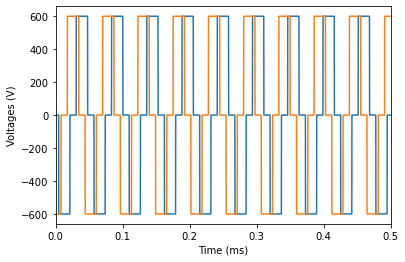

In [5]:
time = np.linspace(0, RunTime, int(RunTime / SampleTime) + 1, endpoint=True)
data = loadmat('voltages.mat')
voltage1 = data['newVoltage']
voltage2 = data['newVoltageShift3']
voltage3 = data['newVoltageShift1']
voltage4 = data['newVoltageShift2']
plt.plot(time * 1e3, voltage1)
plt.plot(time * 1e3, voltage3)
plt.xlim(0, 0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Voltages (V)')
plt.show()

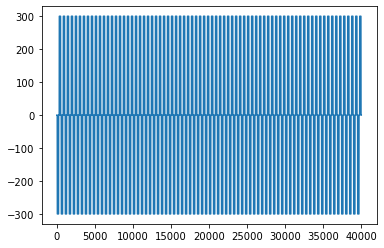

In [6]:
plt.plot(voltage1/2)

7419.141658465024


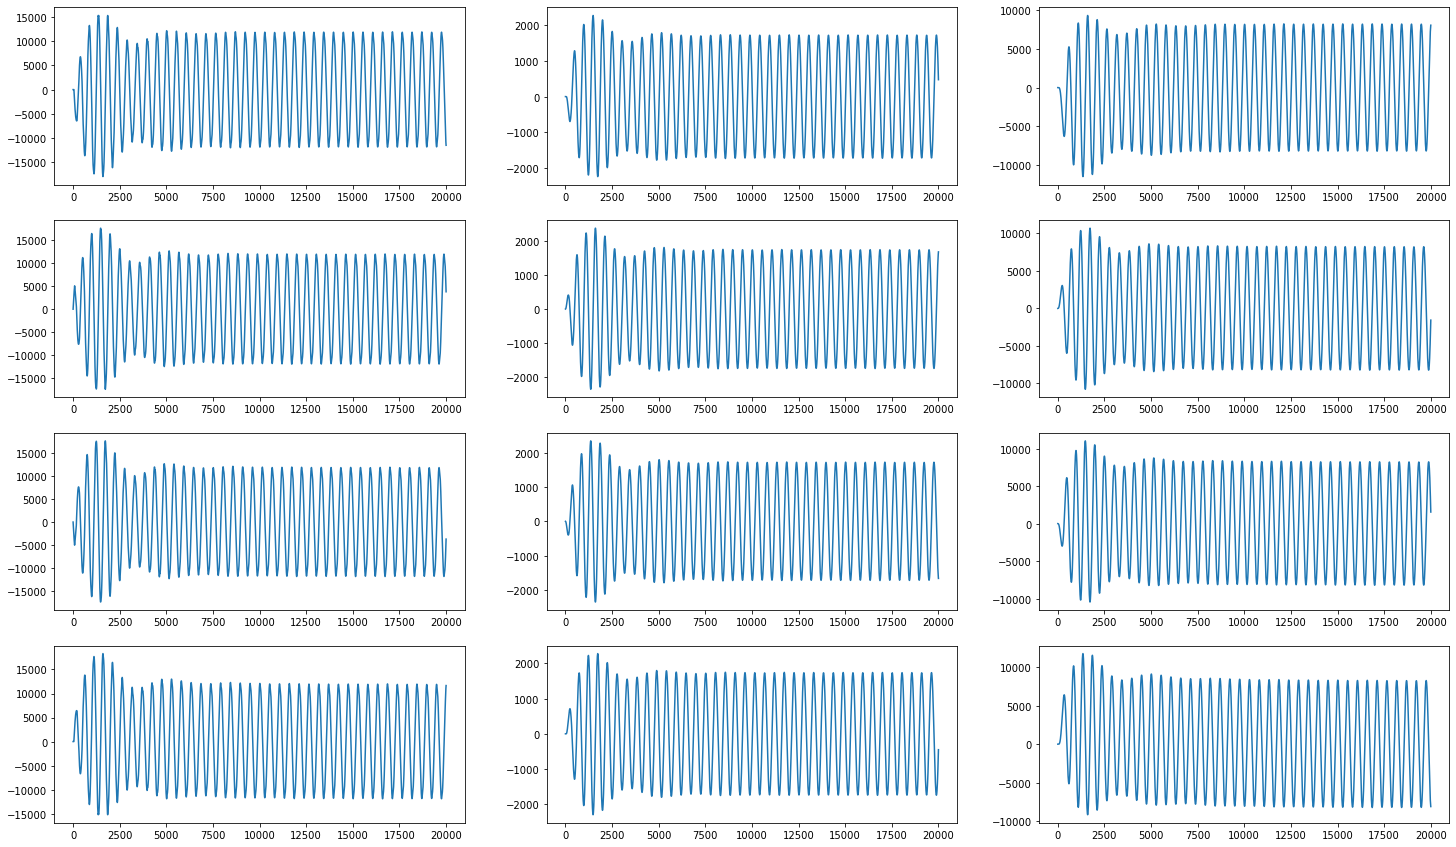

In [7]:
voltages = np.hstack([voltage1, voltage2, voltage3, voltage4])

#Simulating 40001 samples takes too much memory from my poor laptop, so I'm going to cut the shot in half
half_time = time[0:int(len(time)/2)]
half_voltages = voltages[0:int(len(time)/2)]

tout, yout, xout = lsim(
    sysc, 
    half_voltages, 
    half_time
)



tout_test, yout, xout_test_total = lsim(
    sysc, 
    half_voltages/3, #Dropping ampltidue by factor of three to make a rudimentary test set
    half_time
    
)
plt.figure(figsize = (25,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(xout[:,i])
    
print(np.linalg.cond(xout))


In [8]:
#Start with bop,opt, and exact dmd

#Wen we try dmd with 12 modes we get pretty shit prediction. Looking ath the singular values of the dynamics matrix
#indicates that using a rank 4 approximation does the best job of actually capturing the data.
optdmd = BOPDMD(svd_rank = 4,num_trials = 0,compute_A = True)
bopdmd = BOPDMD(svd_rank = 4,num_trials = 25,compute_A = True)
#dmd = DMD(svd_rank = 12, tlsq_rank = 12,exact = True, opt = True)
#Fit all three of our models

#need to transpose our data, and remember this has 10x less samples than the full simulation data so our algorithm can converge

xout_train = xout.T
xout_test = xout_test_total.T

print(np.shape(xout_test))


time_train = tout
time_test = tout_test

optdmd.fit(xout_train,time_train)
bopdmd.fit(xout_train,time_train)

# dmd.fit(xout_train)

#get the statistics for forecasting
reconstruction_mean, reconstruction_variance = bopdmd.forecast(time_train)
forecast_mean, forecast_variance = bopdmd.forecast(time_test)



(12, 20000)


C:\Users\ducks\anaconda3\lib\site-packages\pydmd\plotter.py:189: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000022669D21EE0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(


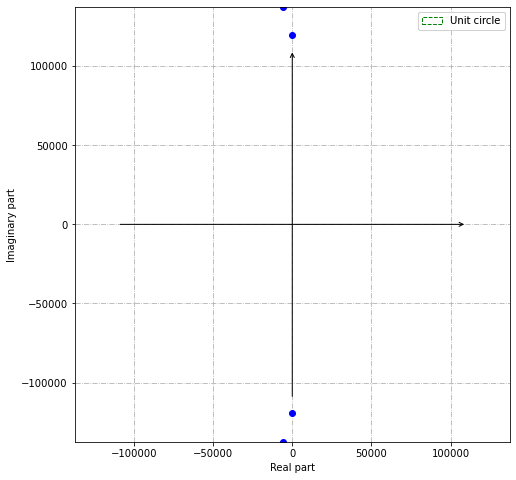

In [9]:
# plt.scatter(np.imag(optdmd.eigs),np.real(optdmd.eigs))

# # plt.scatter(np.imag(bopdmd.eigs),np.real(bopdmd.eigs))

# plt.scatter(np.imag(np.linalg.eigvals(A)),np.real(np.linalg.eigvals(A)))

plot_eigs(bopdmd,show_axes = True)


In [10]:
bopdmd.eigs

array([-6.01620444e+03-137253.34573241j,  1.94643102e+00-119380.85572466j,
        1.94643102e+00+119380.85572466j, -6.01620444e+03+137253.34573241j])

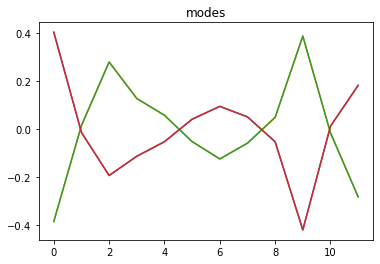

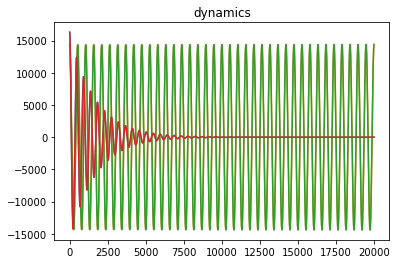

In [11]:
for mode in bopdmd.modes.T:
    plt.plot(mode.real)
    plt.title('modes')
plt.show()

for dynamic in bopdmd.dynamics:
    plt.plot(dynamic.real)
    plt.title('dynamics')
plt.show()

(4, 20000)
(12, 4)


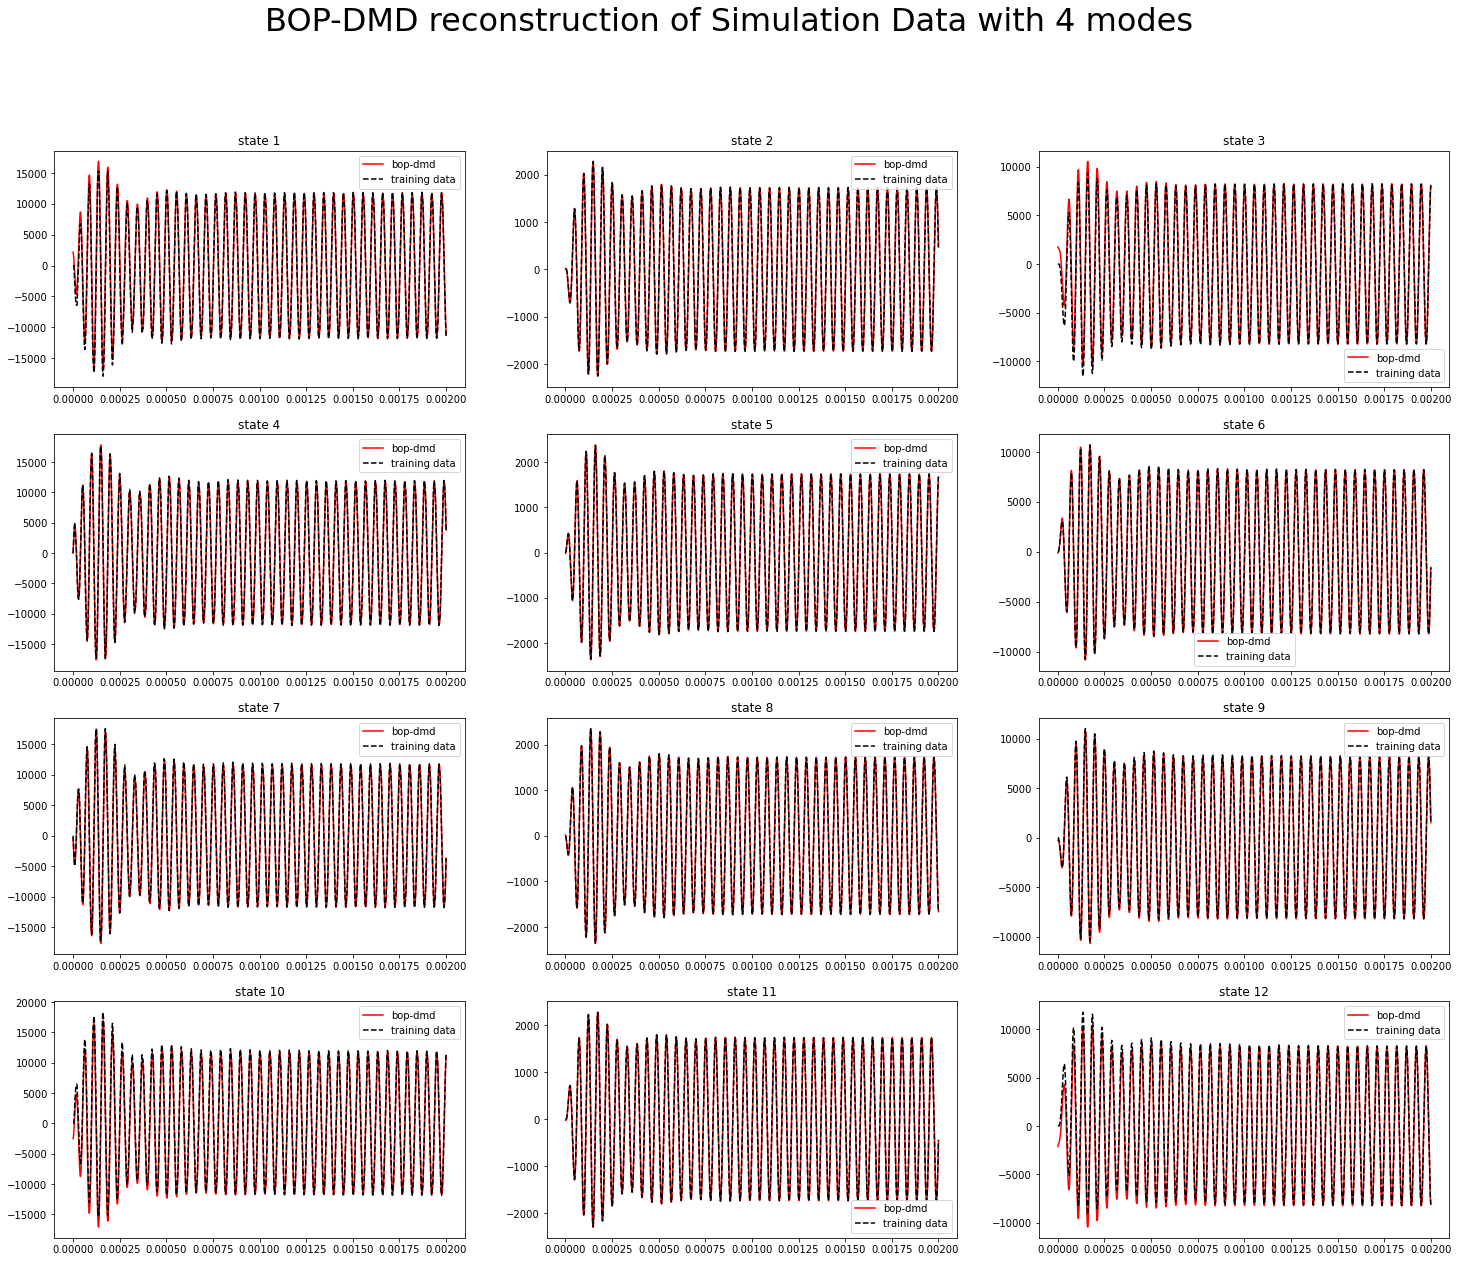

In [12]:
print(np.shape(bopdmd.dynamics.real))
print(np.shape(bopdmd.modes.real))

bopdmd_states = bopdmd.modes@bopdmd.dynamics

count = 0
plt.figure(figsize = (25,20))
plt.suptitle('BOP-DMD reconstruction of Simulation Data with 4 modes',fontsize = 32)
for state,true in zip(bopdmd_states,xout_train):
    plt.subplot(4,3,count+1)
    plt.plot(half_time,state.real,'r')
    plt.plot(half_time,true,'k--')
    plt.legend(['bop-dmd','training data'])
    plt.title(f'state {count+1}')
    count = count + 1
    

## Below we're going to try BOP DMD on a simulated impulse response

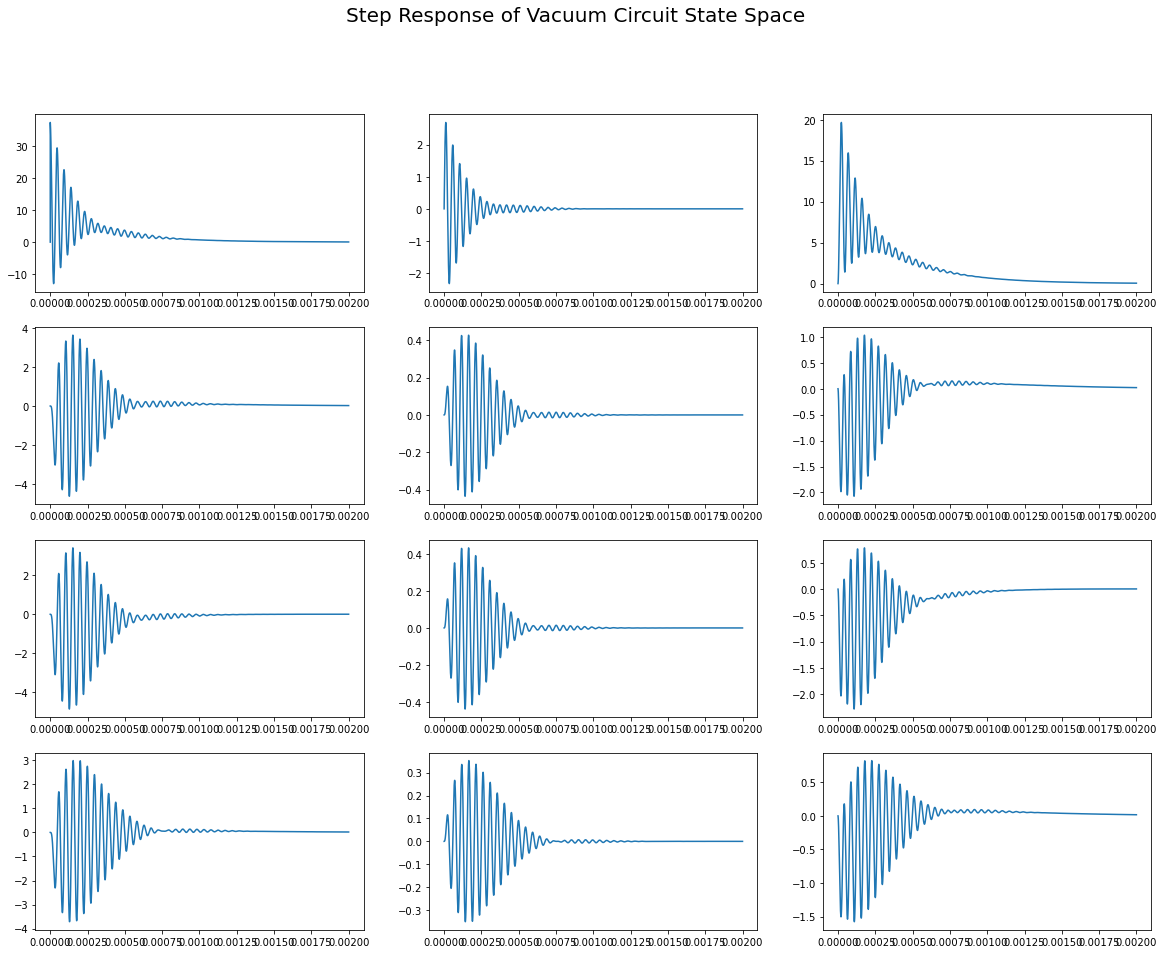

In [13]:
voltage_step = np.zeros(np.shape(half_voltages))

voltage_step[0,0] = 600

tout,yout,xout_step = lsim(sysc,voltage_step,half_time)

plt.figure(figsize = (20,15))
plt.suptitle('Step Response of Vacuum Circuit State Space', fontsize = 20)
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,xout_step[:,i])

In [14]:
#I think 9 modes does the best
optdmd_step_9 = BOPDMD(svd_rank = 9,num_trials = 0,compute_A = True)
bopdmd_step_9 = BOPDMD(svd_rank = 9, num_trials = 10,compute_A = True)

bopdmd_step_9.fit(xout_step.T,half_time)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 143697.92026192203. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


Text(0.5, 1.0, 'Comparison of BOPDMD eigenvalues and True Eigenvalues')

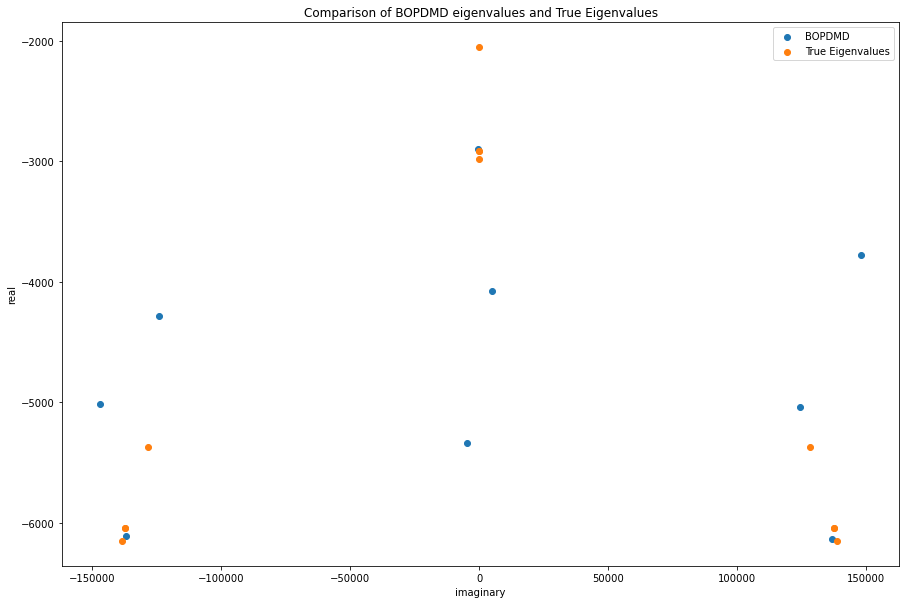

In [15]:
plt.figure(figsize = (15,10))
plt.scatter(np.imag(bopdmd_step_9.eigs),np.real(bopdmd_step_9.eigs))
plt.scatter(np.imag(np.linalg.eigvals(A)),np.real(np.linalg.eigvals(A)))

plt.legend(['BOPDMD', 'True Eigenvalues'])

plt.xlabel('imaginary')
plt.ylabel('real')
plt.title('Comparison of BOPDMD eigenvalues and True Eigenvalues')


## Now let's take the A matrix that comes out of BOPDMD and simulate the step response and compare to the training data

In [16]:
np.linalg.eigvals(A)

array([-5374.04778628+128310.86801552j, -5374.04778628-128310.86801552j,
       -6150.9991369 +138653.66264826j, -6150.9991369 -138653.66264826j,
       -6044.9626896 +137273.04653728j, -6044.9626896 -137273.04653728j,
       -6044.96263763+137273.04653074j, -6044.96263763-137273.04653074j,
       -2052.57854051     +0.j        , -2915.80446125     +0.j        ,
       -2915.80452169     +0.j        , -2983.64806906     +0.j        ])

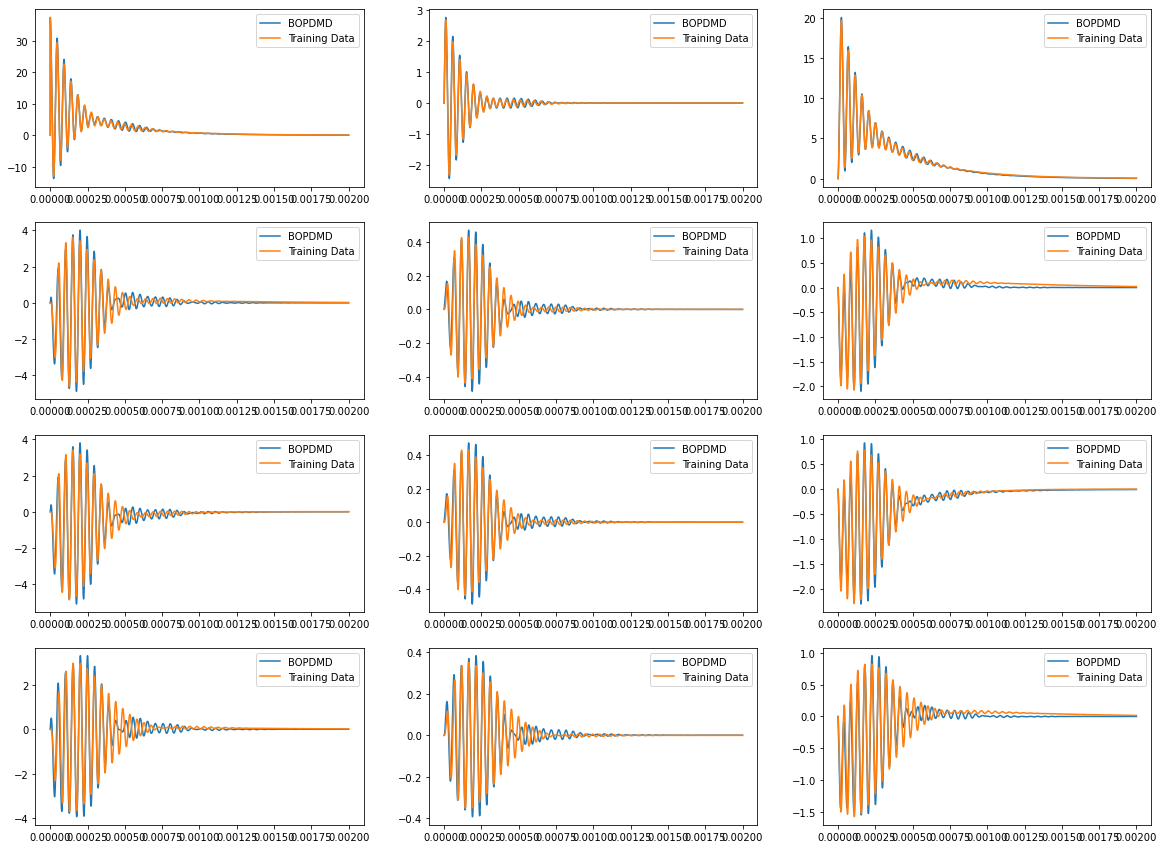

In [17]:
Atilde = bopdmd_step_9.A

Btilde = B # B matrix is the ground truth

tout,yout,xout_bopdmd_step_9 = lsim((Atilde,Btilde,C,D),voltage_step,half_time)

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_step_9[:,i]))
    plt.plot(half_time,xout_step[:,i])
    plt.legend(['BOPDMD', 'Training Data'])

In [19]:
tout,yout,xout_bopdmd_full_response_9 = lsim((Atilde,Btilde,C,D),half_voltages,half_time)

print(np.shape(xout_bopdmd_full_response_9))
print(np.shape(xout_train))

(20000, 12)
(12, 20000)


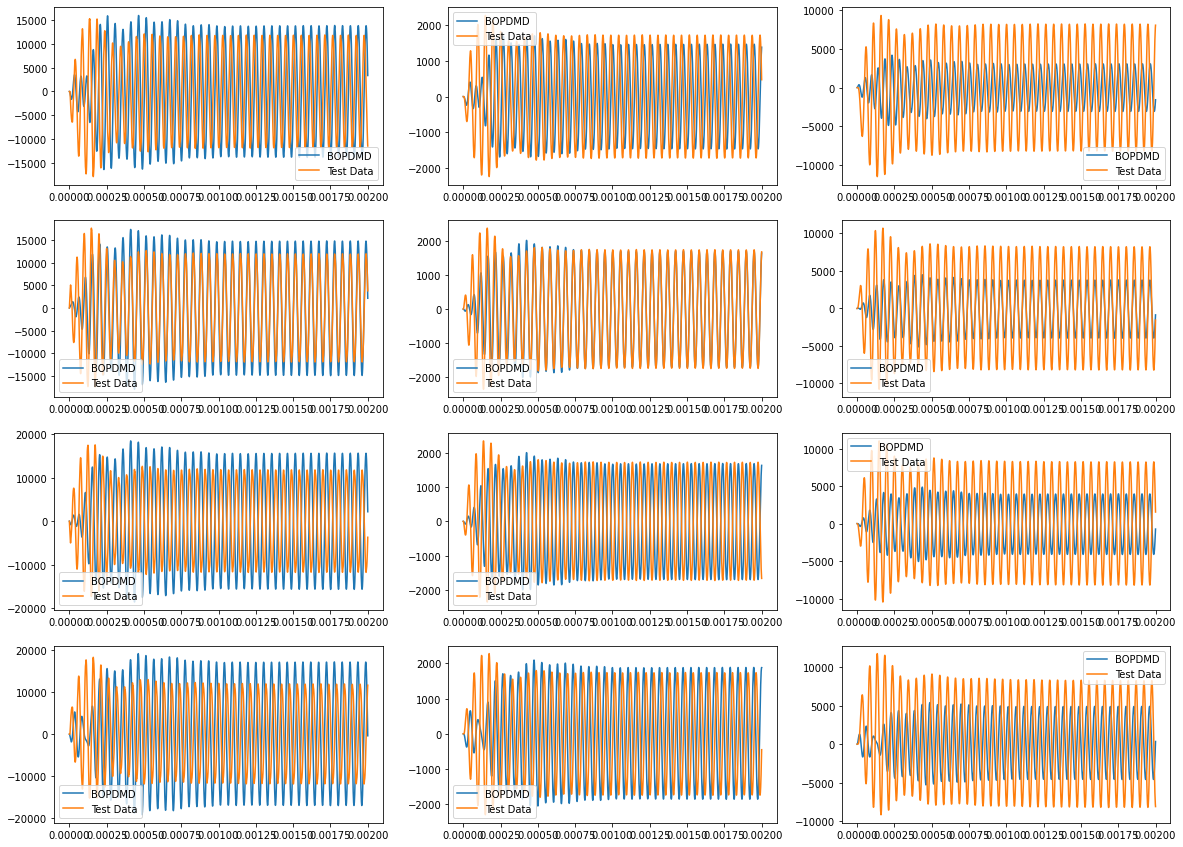

In [20]:
#With 9 modes we need to scale down by a factor of roughly 10 to match our model
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_full_response_9[:,i])/10)
    plt.plot(half_time,xout_train.T[:,i])
    plt.legend(['BOPDMD', 'Test Data'])

In [21]:
np.sum(np.abs(half_voltages))/2000

15394.5

In [22]:
#Plot the differences between the rank truncation and the scaling factor error in the test data

In [23]:
# Boyce and DePrima 

In [24]:
np.linalg.eigvals(A)

array([-5374.04778628+128310.86801552j, -5374.04778628-128310.86801552j,
       -6150.9991369 +138653.66264826j, -6150.9991369 -138653.66264826j,
       -6044.9626896 +137273.04653728j, -6044.9626896 -137273.04653728j,
       -6044.96263763+137273.04653074j, -6044.96263763-137273.04653074j,
       -2052.57854051     +0.j        , -2915.80446125     +0.j        ,
       -2915.80452169     +0.j        , -2983.64806906     +0.j        ])

In [25]:
#Try to fit more than 12 modes on this data and see what happens


In [26]:

#There are 167 samples of a non-zero pulse for each 600 volt square wave

In [27]:
#Now let's try with rank 10, and so on

#I think 9 modes does the best
optdmd_step_10 = BOPDMD(svd_rank = 10,num_trials = 0,compute_A = True)
bopdmd_step_10 = BOPDMD(svd_rank = 10, num_trials = 10,compute_A = True)

bopdmd_step_10.fit(xout_step.T,half_time)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 143697.92026192203. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


In [28]:
optdmd_step_11 = BOPDMD(svd_rank = 11,num_trials = 0,compute_A = True)
bopdmd_step_11 = BOPDMD(svd_rank = 11, num_trials = 10,compute_A = True)

bopdmd_step_11.fit(xout_step.T,half_time)

In [29]:
optdmd_step_12 = BOPDMD(svd_rank = 12,num_trials = 0,compute_A = True)
bopdmd_step_12 = BOPDMD(svd_rank = 12, num_trials = 10,compute_A = True)

bopdmd_step_12.fit(xout_step.T,half_time)

In [30]:
optdmd_step_14 = BOPDMD(svd_rank = 14,num_trials = 0,compute_A = True)
bopdmd_step_14 = BOPDMD(svd_rank = 14, num_trials = 10,compute_A = True)

bopdmd_step_14.fit(xout_step.T,half_time)

In [31]:
optdmd_step_16 = BOPDMD(svd_rank = 16,num_trials = 0,compute_A = True)
bopdmd_step_16 = BOPDMD(svd_rank = 16, num_trials = 10,compute_A = True)

bopdmd_step_16.fit(xout_step.T,half_time)

In [32]:
optdmd_step_18 = BOPDMD(svd_rank = 18,num_trials = 0,compute_A = True)
bopdmd_step_18 = BOPDMD(svd_rank = 18, num_trials = 10,compute_A = True)

bopdmd_step_18.fit(xout_step.T,half_time)

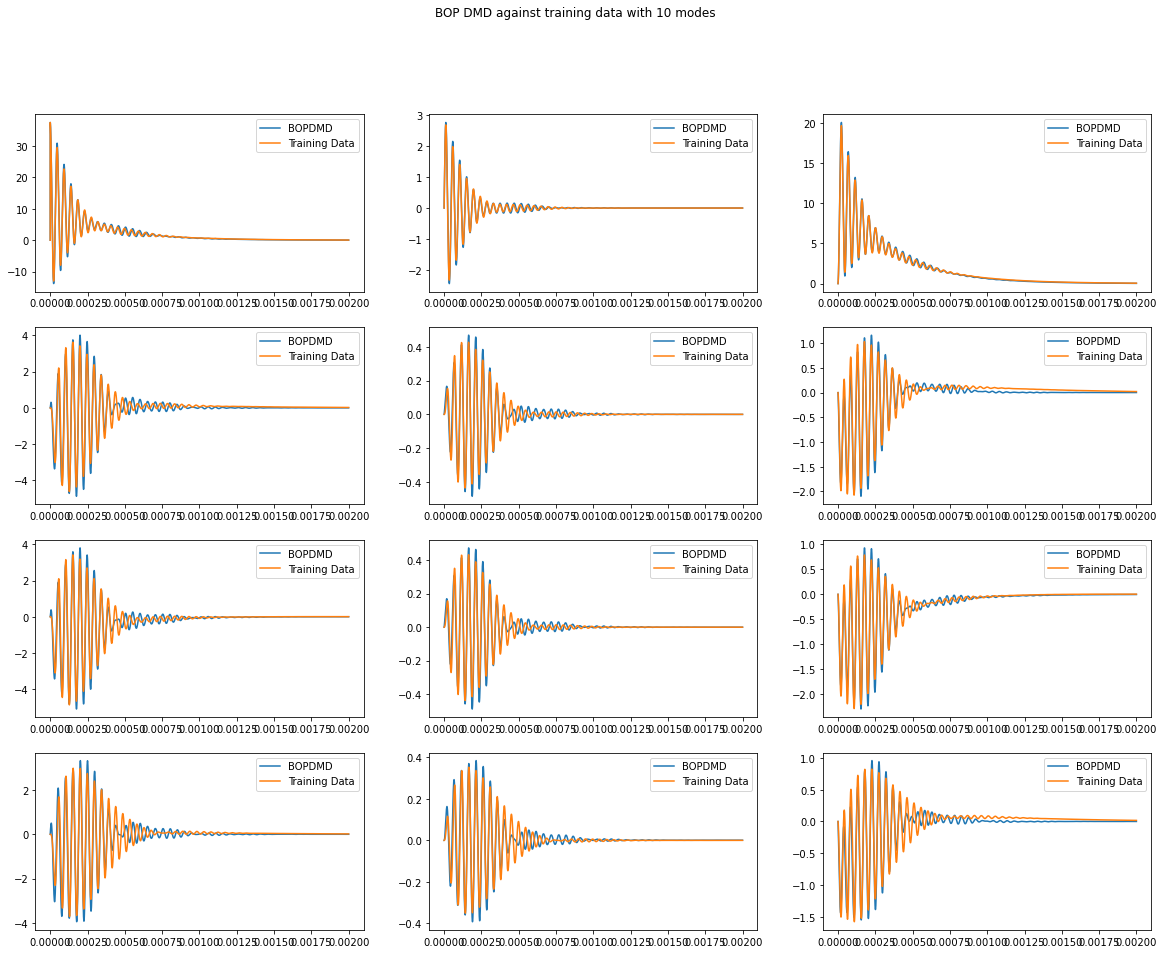

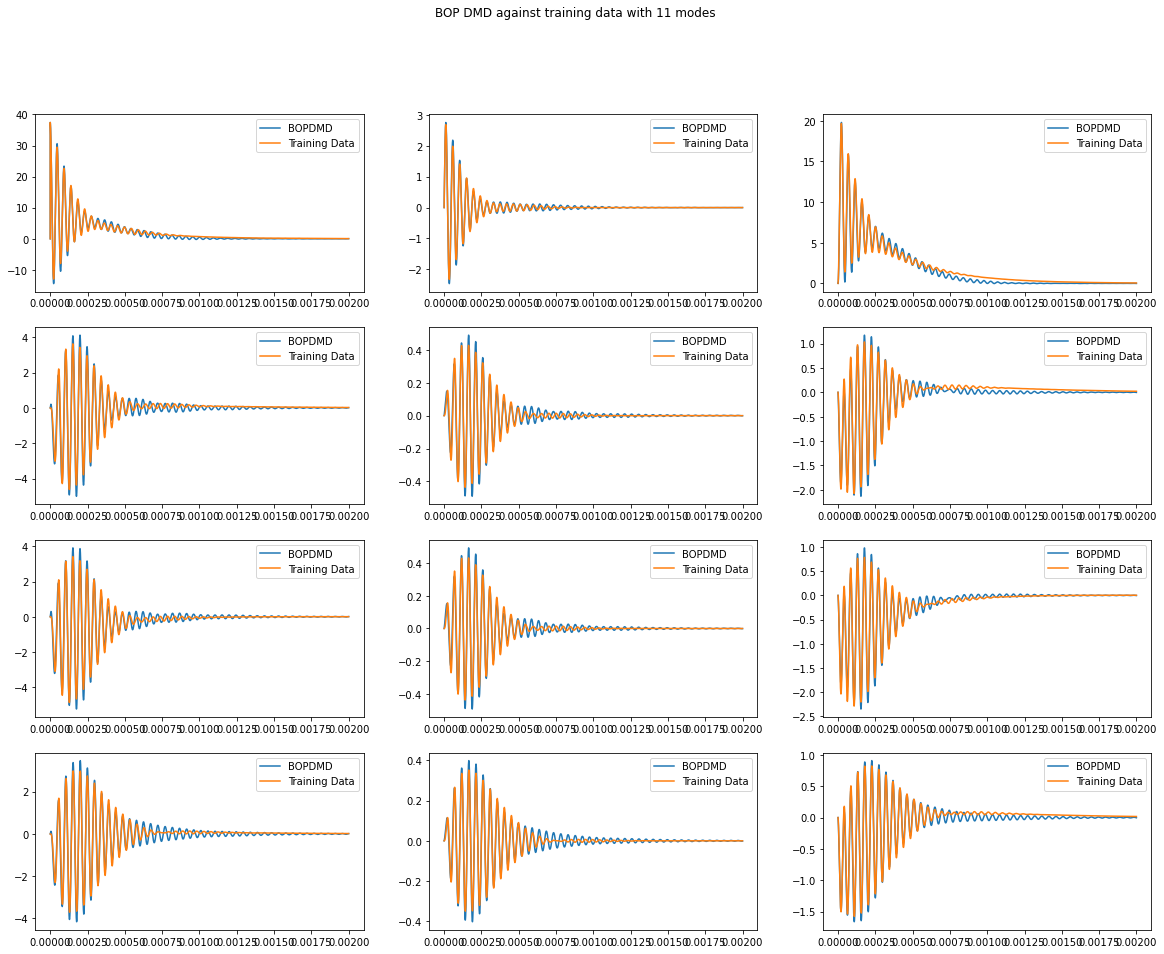

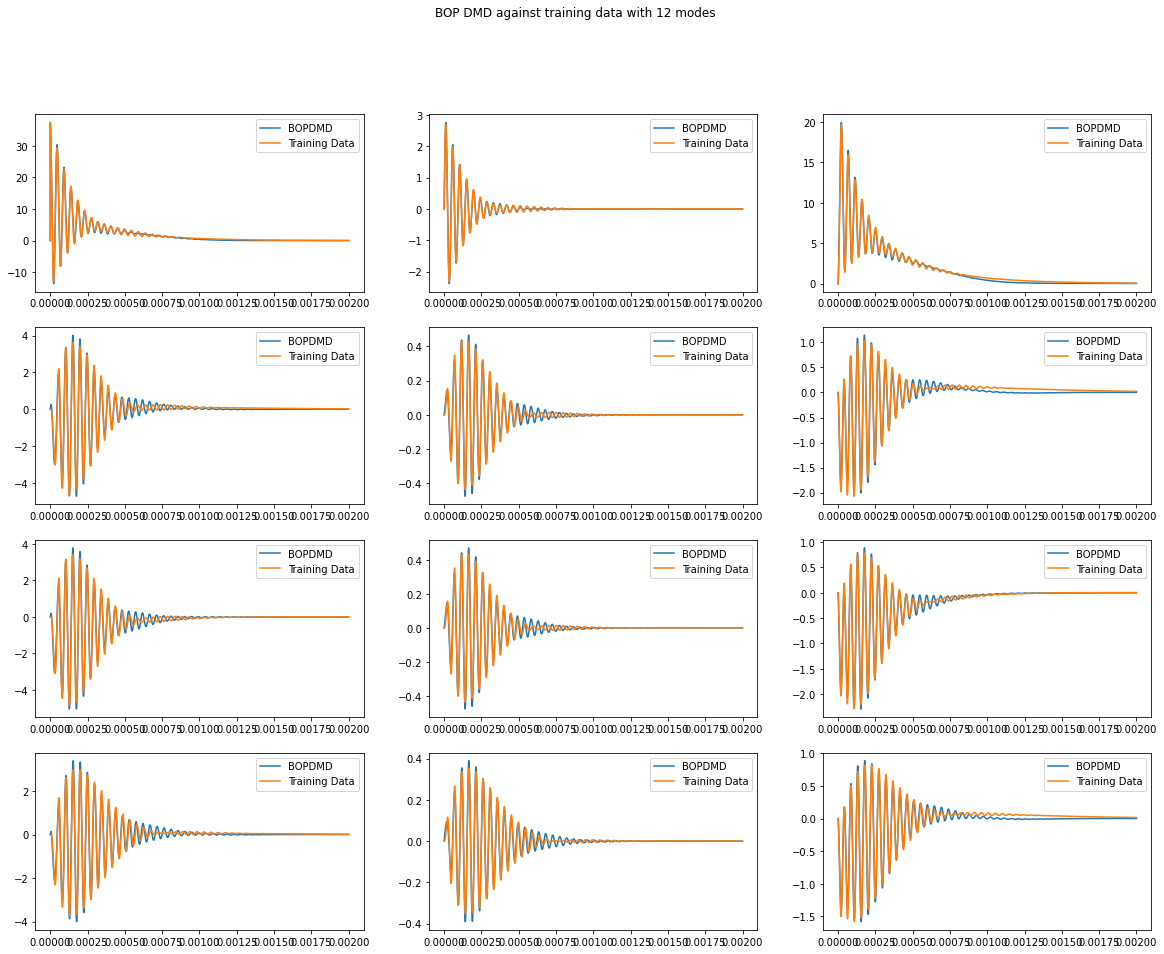

In [33]:
Atilde = bopdmd_step_10.A

Btilde = B # B matrix is the ground truth

tout,yout,xout_bopdmd_step_10 = lsim((Atilde,Btilde,C,D),voltage_step,half_time)
#This is the test data below
tout,yout,xout_bopdmd_full_response_10 = lsim((Atilde,Btilde,C,D),half_voltages,half_time)

Atilde = bopdmd_step_11.A

Btilde = B # B matrix is the ground truth

tout,yout,xout_bopdmd_step_11 = lsim((Atilde,Btilde,C,D),voltage_step,half_time)
#This is the test data below
tout,yout,xout_bopdmd_full_response_11 = lsim((Atilde,Btilde,C,D),half_voltages,half_time)



Atilde = bopdmd_step_12.A

Btilde = B # B matrix is the ground truth

tout,yout,xout_bopdmd_step_12 = lsim((Atilde,Btilde,C,D),voltage_step,half_time)
#This is the test data below
tout,yout,xout_bopdmd_full_response_12 = lsim((Atilde,Btilde,C,D),half_voltages,half_time)


plt.figure(figsize = (20,15))
plt.suptitle('BOP DMD against training data with 10 modes')
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_step_9[:,i]))
    plt.plot(half_time,xout_step[:,i])
    plt.legend(['BOPDMD', 'Training Data'])
    


plt.figure(figsize = (20,15))
plt.suptitle('BOP DMD against training data with 11 modes')
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_step_11[:,i]))
    plt.plot(half_time,xout_step[:,i])
    plt.legend(['BOPDMD', 'Training Data'])
    
plt.figure(figsize = (20,15))
plt.suptitle('BOP DMD against training data with 12 modes')
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_step_12[:,i]))
    plt.plot(half_time,xout_step[:,i])
    plt.legend(['BOPDMD', 'Training Data'])

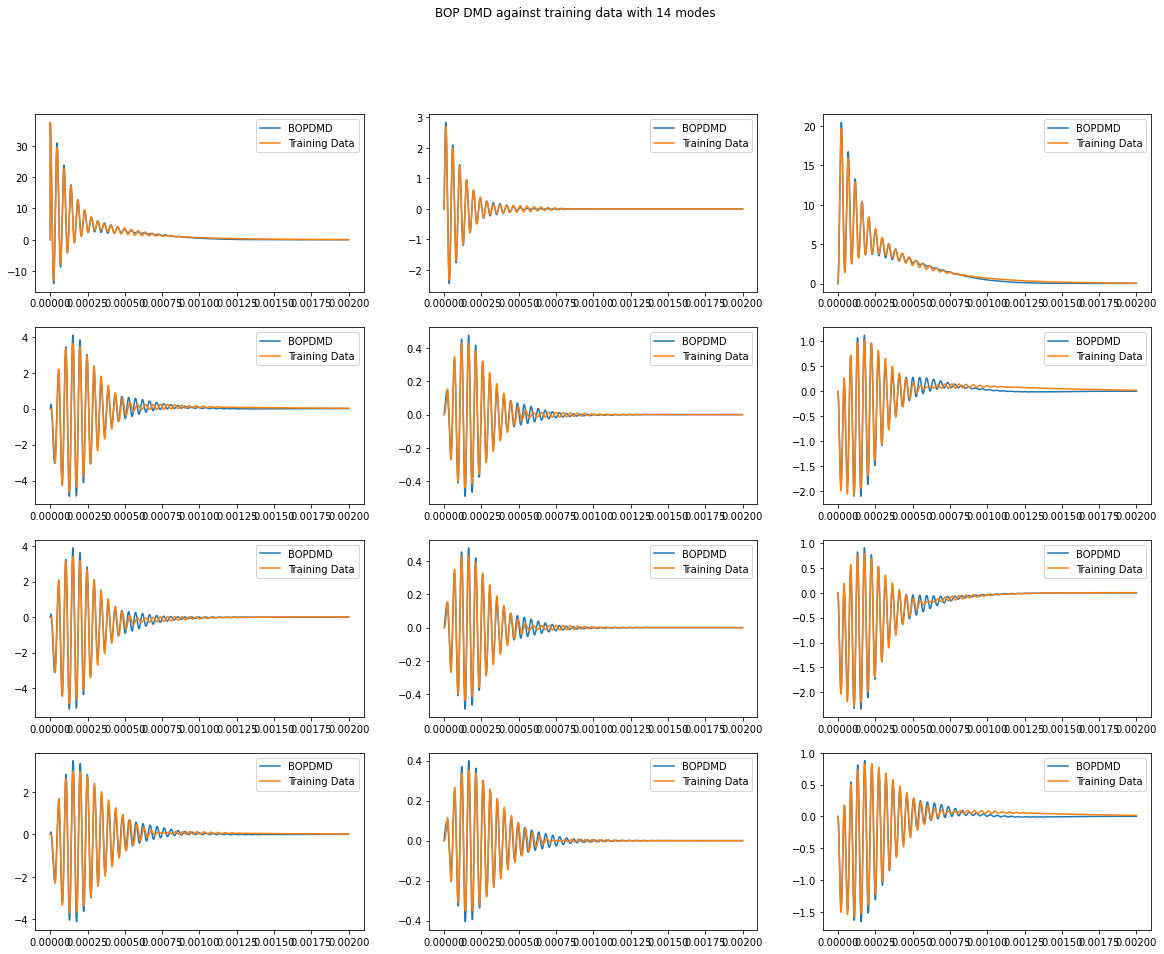

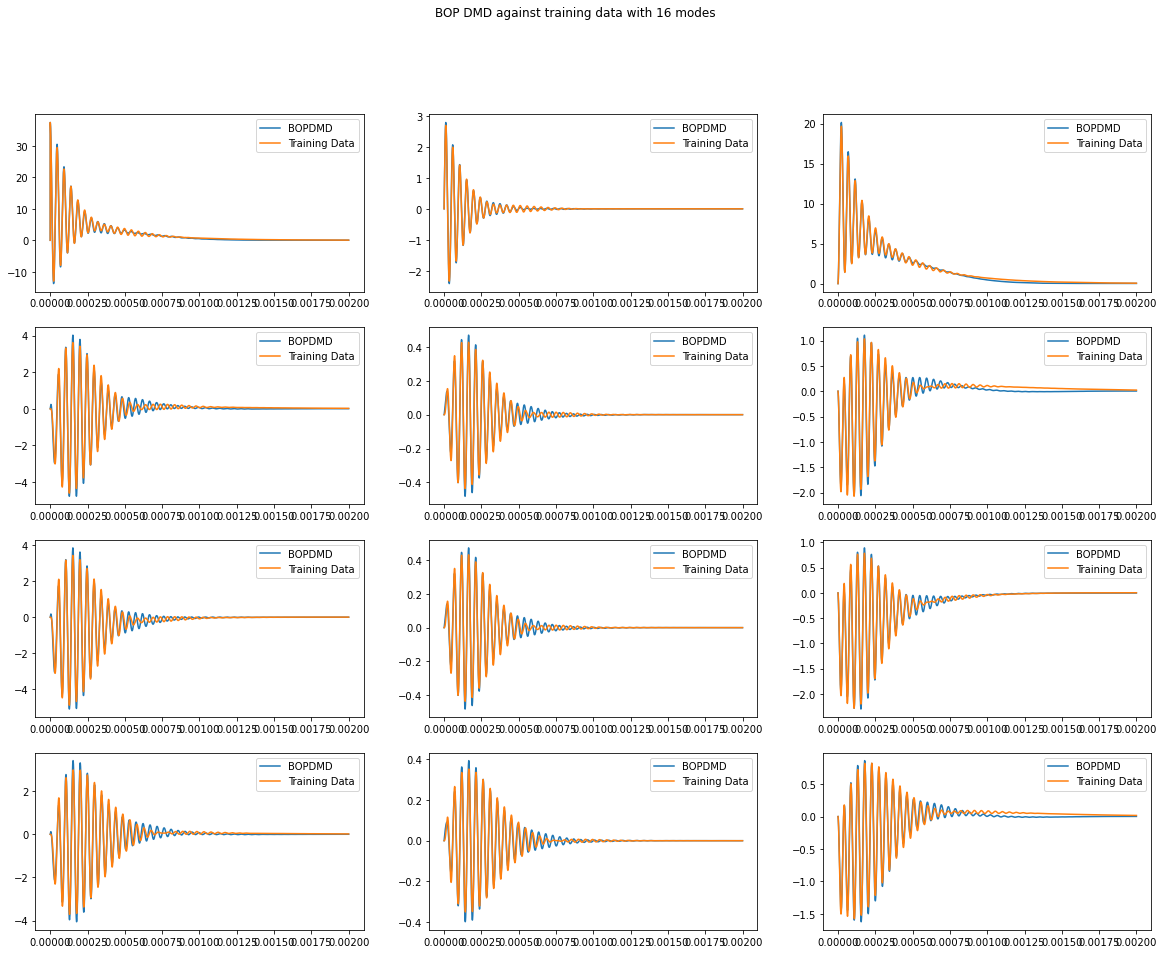

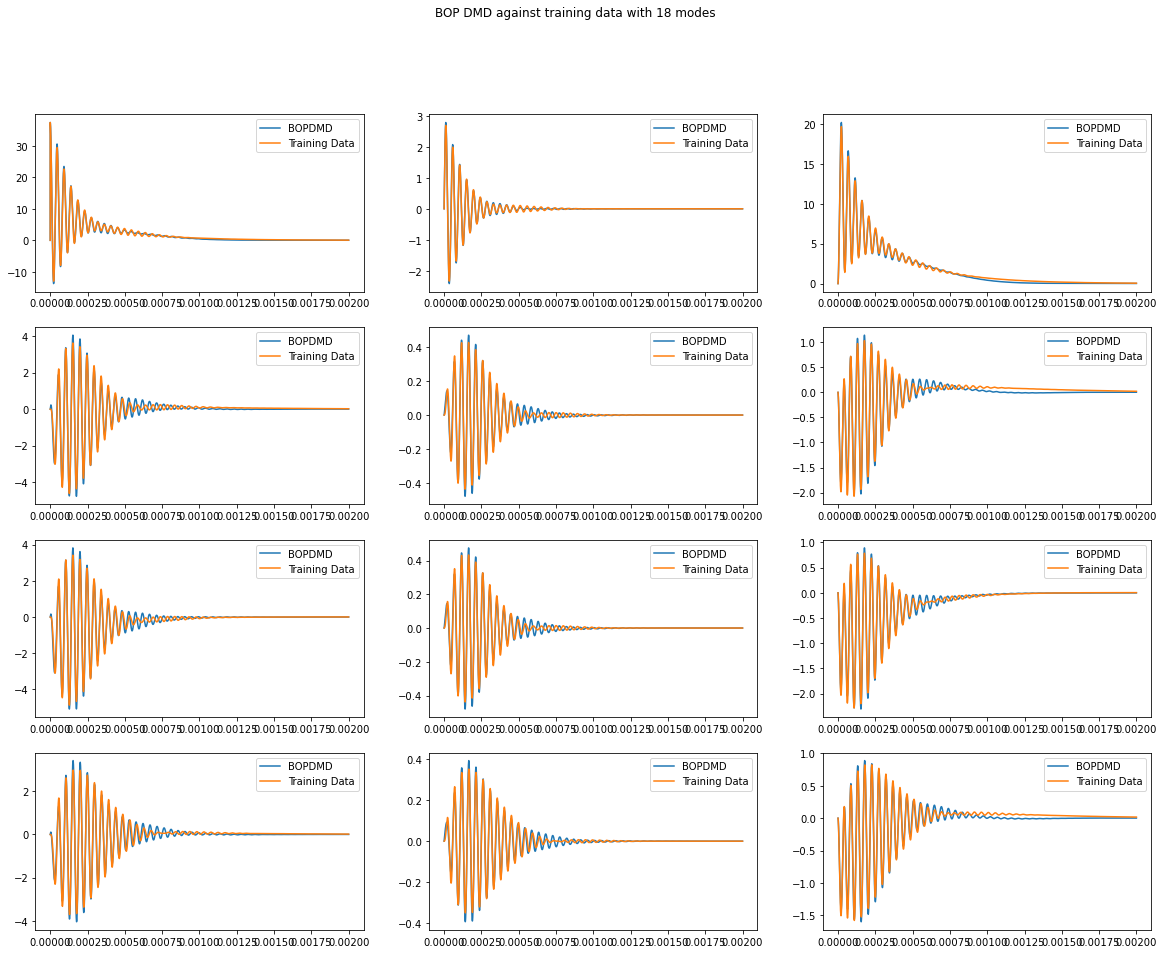

In [34]:
Atilde = bopdmd_step_14.A

Btilde = B # B matrix is the ground truth

tout,yout,xout_bopdmd_step_14 = lsim((Atilde,Btilde,C,D),voltage_step,half_time)
#This is the test data below
tout,yout,xout_bopdmd_full_response_14 = lsim((Atilde,Btilde,C,D),half_voltages,half_time)

Atilde = bopdmd_step_16.A

Btilde = B # B matrix is the ground truth

tout,yout,xout_bopdmd_step_16 = lsim((Atilde,Btilde,C,D),voltage_step,half_time)
#This is the test data below
tout,yout,xout_bopdmd_full_response_16 = lsim((Atilde,Btilde,C,D),half_voltages,half_time)

Atilde = bopdmd_step_18.A

Btilde = B # B matrix is the ground truth

tout,yout,xout_bopdmd_step_18 = lsim((Atilde,Btilde,C,D),voltage_step,half_time)
#This is the test data below
tout,yout,xout_bopdmd_full_response_18 = lsim((Atilde,Btilde,C,D),half_voltages,half_time)


plt.figure(figsize = (20,15))
plt.suptitle('BOP DMD against training data with 14 modes')
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_step_14[:,i]))
    plt.plot(half_time,xout_step[:,i])
    plt.legend(['BOPDMD', 'Training Data'])
    
    
Atilde = bopdmd_step_11.A

Btilde = B # B matrix is the ground truth

tout,yout,xout_bopdmd_step_11 = lsim((Atilde,Btilde,C,D),voltage_step,half_time)

plt.figure(figsize = (20,15))
plt.suptitle('BOP DMD against training data with 16 modes')
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_step_16[:,i]))
    plt.plot(half_time,xout_step[:,i])
    plt.legend(['BOPDMD', 'Training Data'])
    
plt.figure(figsize = (20,15))
plt.suptitle('BOP DMD against training data with 18 modes')
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_step_18[:,i]))
    plt.plot(half_time,xout_step[:,i])
    plt.legend(['BOPDMD', 'Training Data'])

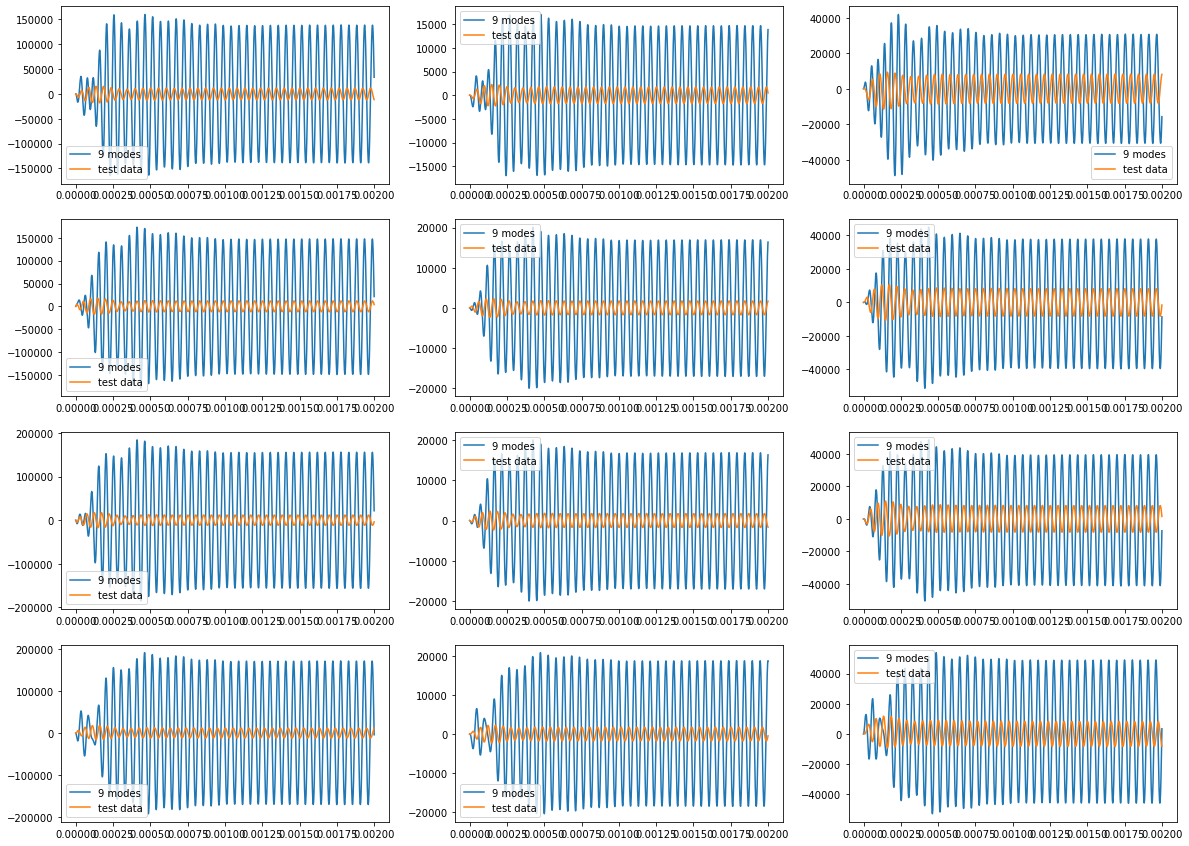

In [35]:
plt.figure(figsize = (20,15))




for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_full_response_9[:,i]))

    plt.plot(half_time,xout_train.T[:,i])
    plt.legend(['9 modes', 'test data'])
#     plt.legend(['9 modes','10 modes','11 modes','12 modes' 'Test Data'])

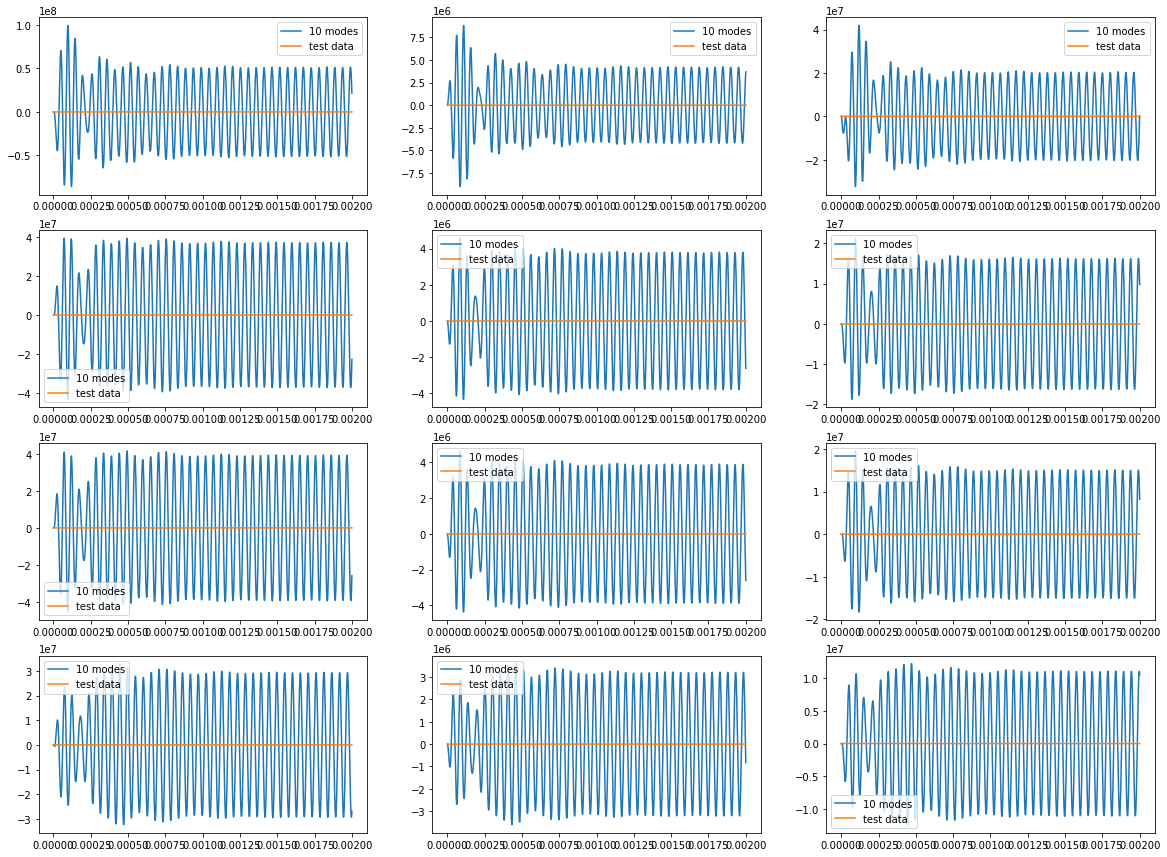

In [36]:
plt.figure(figsize = (20,15))




for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_full_response_10[:,i]))

    plt.plot(half_time,xout_train.T[:,i])
    plt.legend(['10 modes', 'test data'])

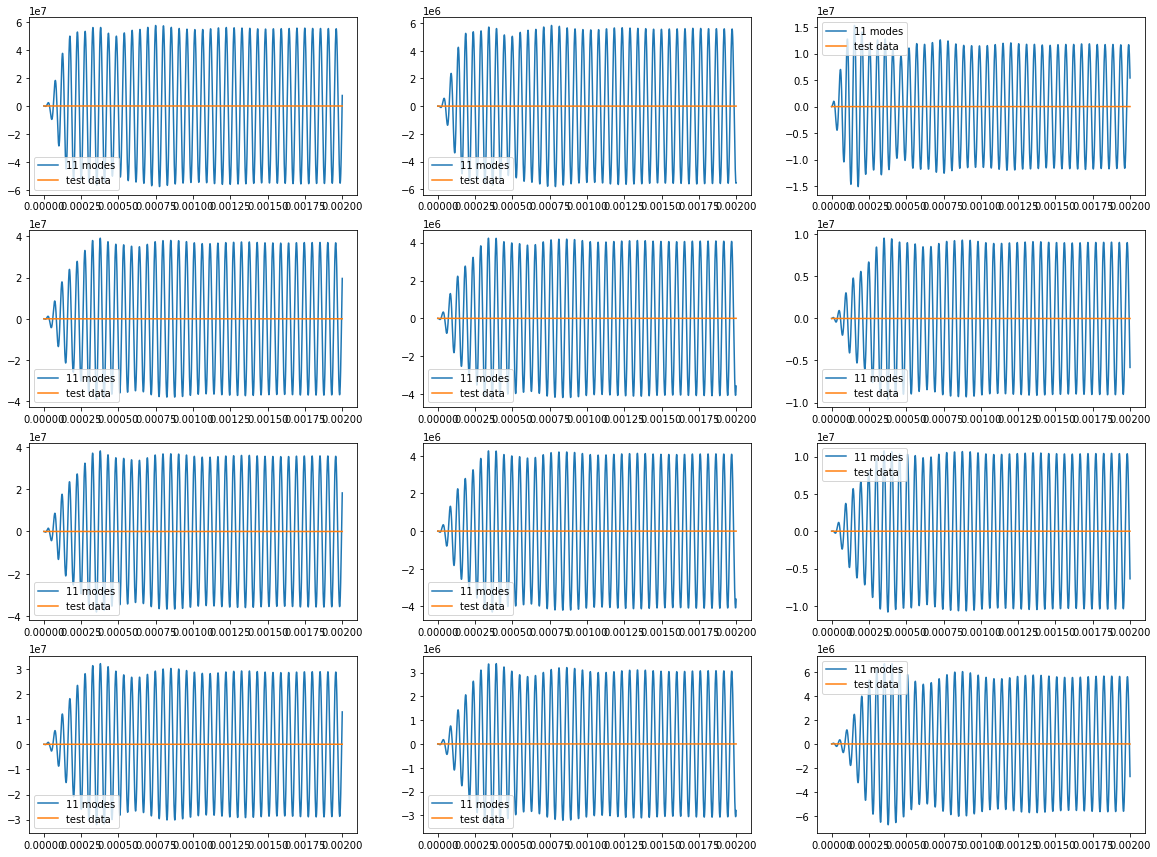

In [37]:
plt.figure(figsize = (20,15))




for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_full_response_11[:,i]))

    plt.plot(half_time,xout_train.T[:,i])
    plt.legend(['11 modes', 'test data'])

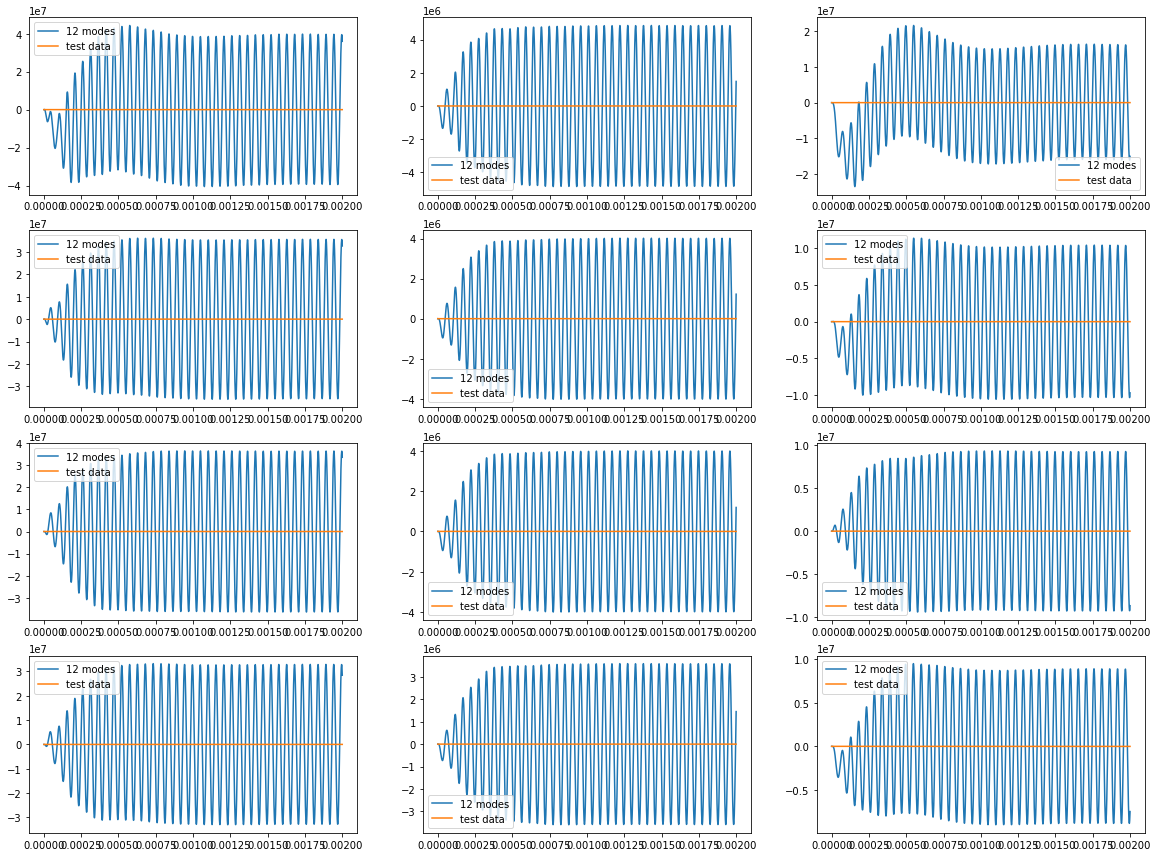

In [38]:
plt.figure(figsize = (20,15))




for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_full_response_12[:,i]))

    plt.plot(half_time,xout_train.T[:,i])
    plt.legend(['12 modes', 'test data'])

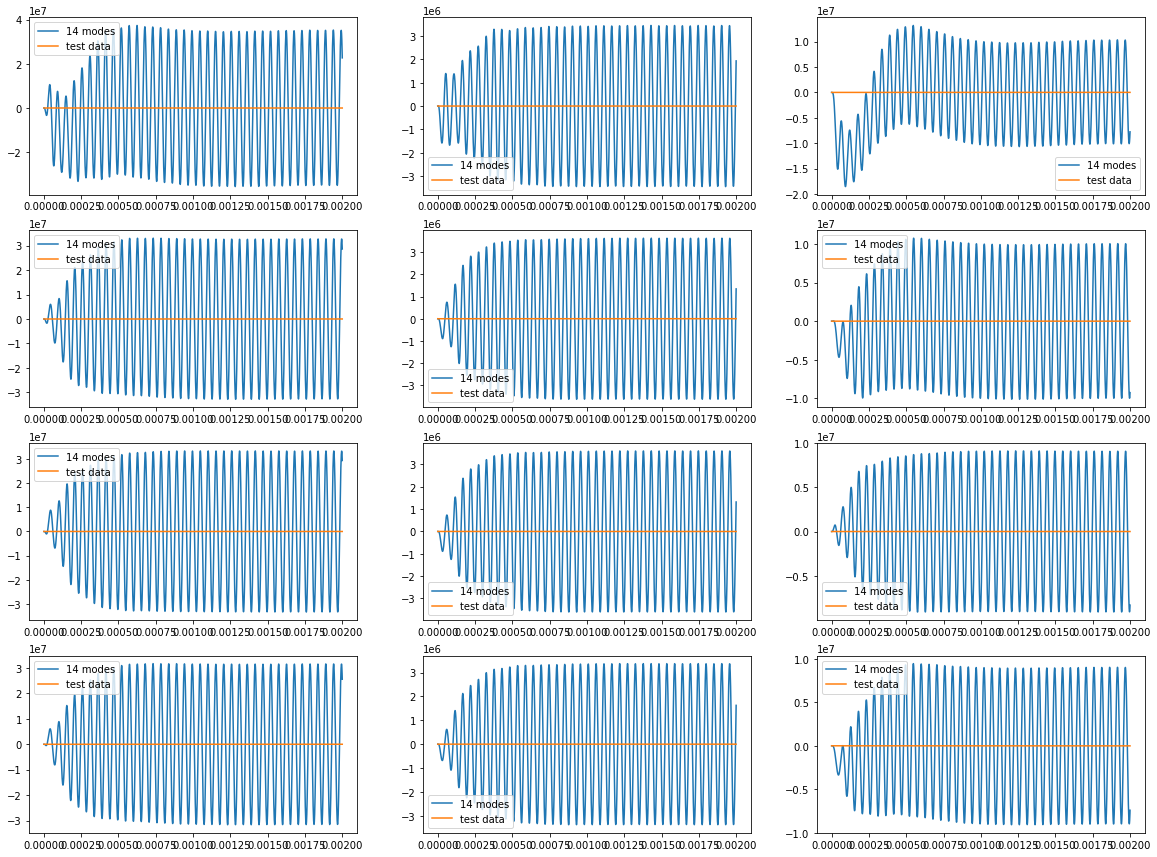

In [39]:
plt.figure(figsize = (20,15))




for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_full_response_14[:,i]))

    plt.plot(half_time,xout_train.T[:,i])
    plt.legend(['14 modes', 'test data'])

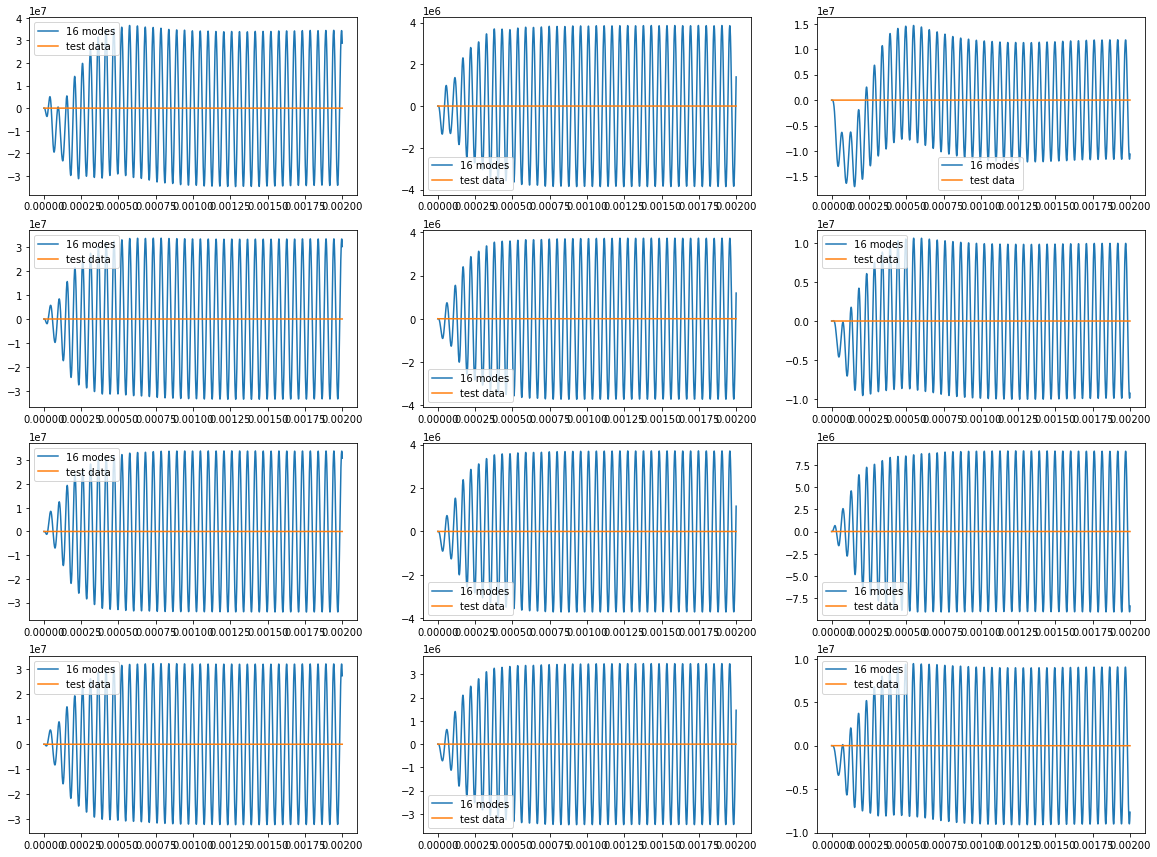

In [40]:
plt.figure(figsize = (20,15))




for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_full_response_16[:,i]))

    plt.plot(half_time,xout_train.T[:,i])
    plt.legend(['16 modes', 'test data'])

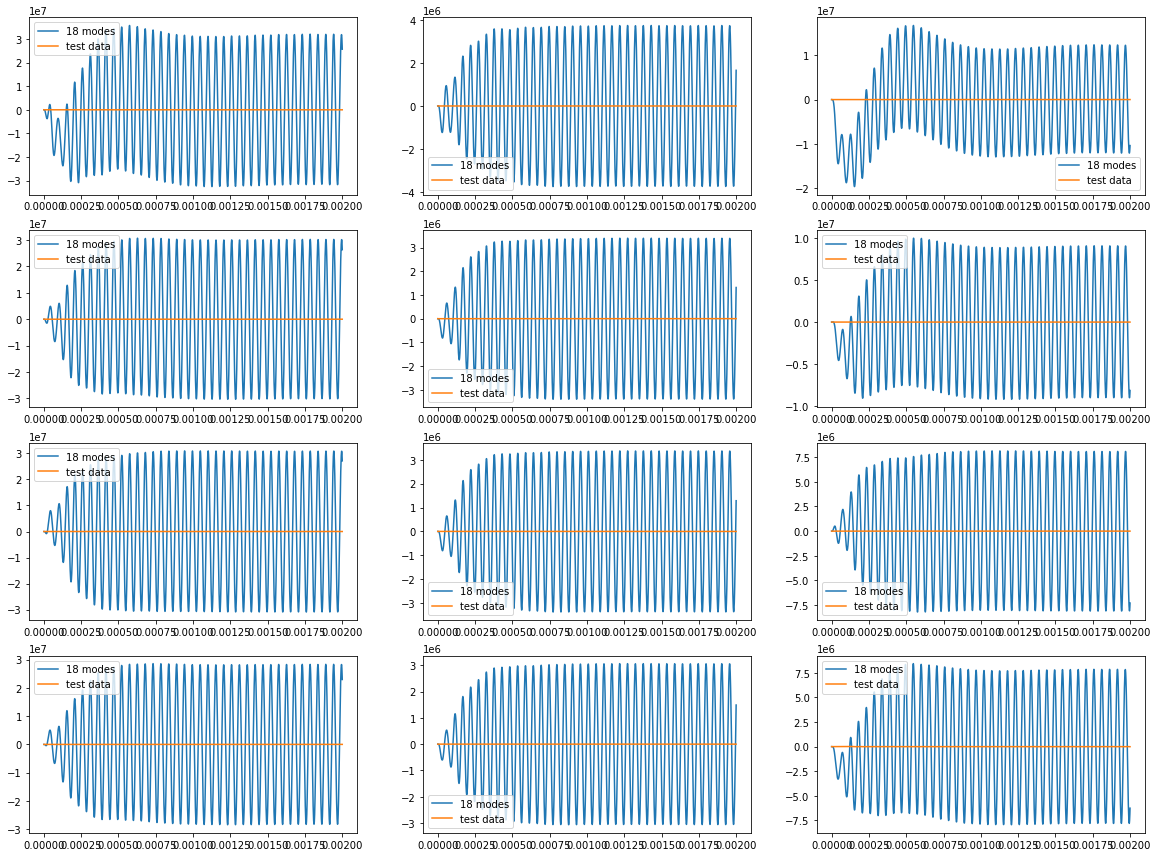

In [41]:
plt.figure(figsize = (20,15))




for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_full_response_18[:,i]))

    plt.plot(half_time,xout_train.T[:,i])
    plt.legend(['18 modes', 'test data'])

In [42]:
optdmd_step_8 = BOPDMD(svd_rank = 8,num_trials = 0,compute_A = True)
bopdmd_step_8 = BOPDMD(svd_rank = 8, num_trials = 10,compute_A = True)

bopdmd_step_8.fit(xout_step.T,half_time)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 143697.92026192203. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


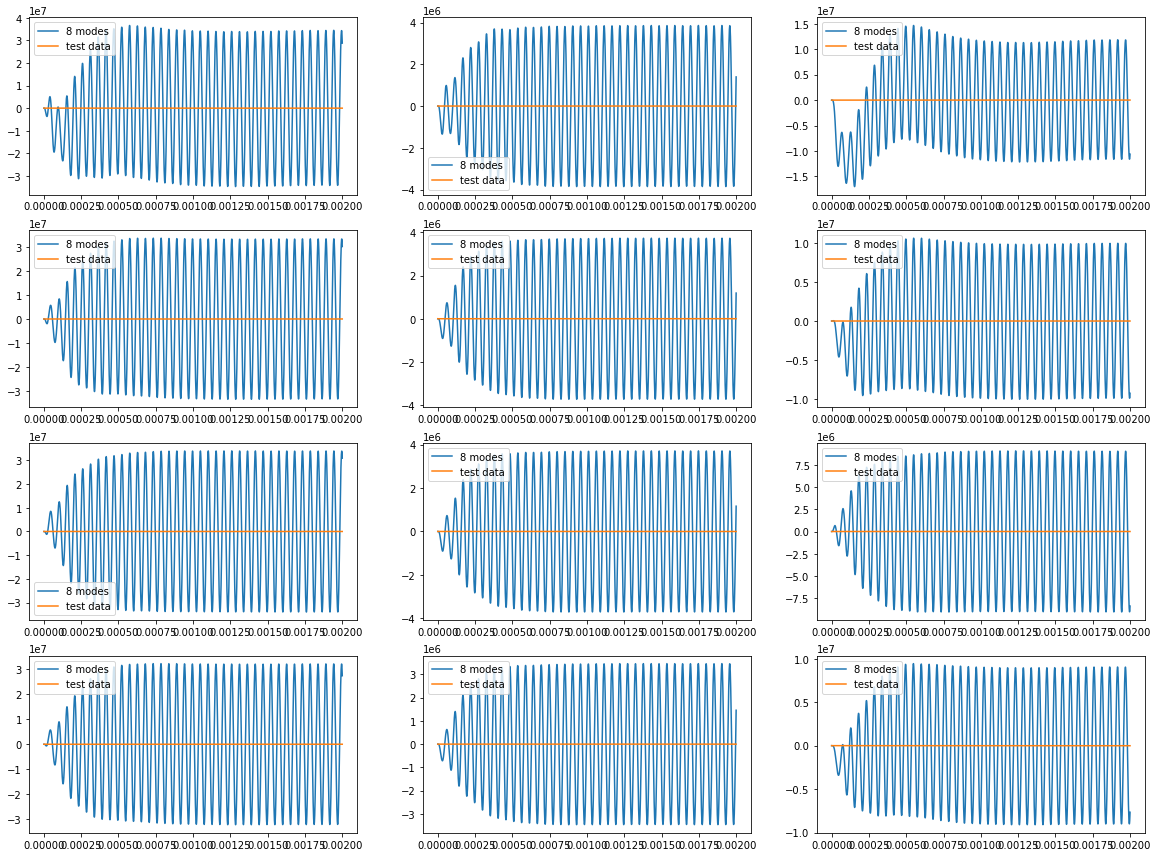

In [43]:
Atilde = bopdmd_step_8.A

Btilde = B # B matrix is the ground truth

tout,yout,xout_bopdmd_step_8 = lsim((Atilde,Btilde,C,D),voltage_step,half_time)


plt.figure(figsize = (20,15))




for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_full_response_16[:,i]))

    plt.plot(half_time,xout_train.T[:,i])
    plt.legend(['8 modes', 'test data'])

In [53]:
optdmd_step_4 = BOPDMD(svd_rank = 5,num_trials = 0,compute_A = True)
bopdmd_step_4 = BOPDMD(svd_rank = 5, num_trials = 5,compute_A = True)

bopdmd_step_4.fit(xout_step.T,half_time)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 143697.92026192203. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


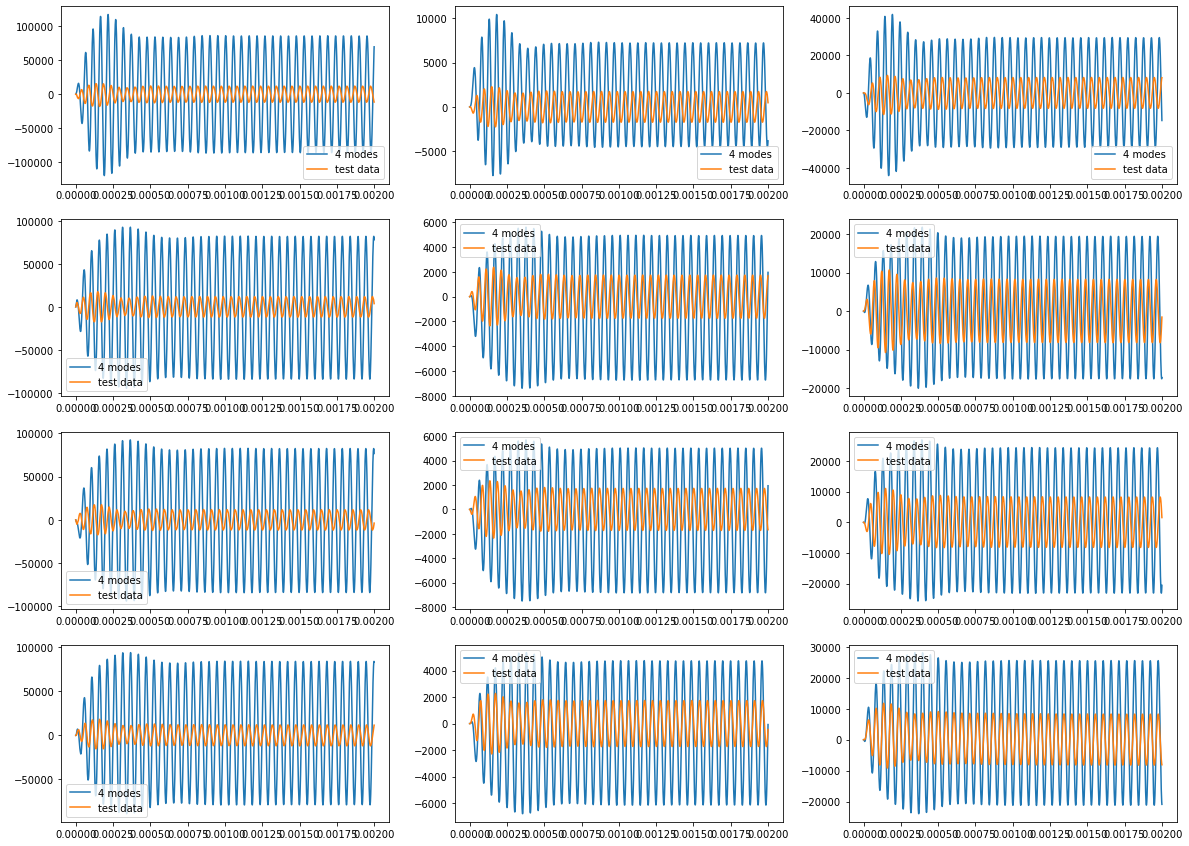

In [54]:
Atilde = bopdmd_step_4.A

Btilde = B # B matrix is the ground truth

tout,yout,xout_bopdmd_step_4 = lsim((Atilde,Btilde,C,D),voltage_step,half_time)
tout,yout,xout_bopdmd_full_response_4 = lsim((Atilde,Btilde,C,D),half_voltages,half_time)

plt.figure(figsize = (20,15))




for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bopdmd_full_response_4[:,i]))

    plt.plot(half_time,xout_train.T[:,i])
    plt.legend(['4 modes', 'test data'])

In [55]:
print(np.linalg.eigvals(Atilde))

[-6.09718602e+03-1.37811898e+05j -5.42849158e+03-1.28288581e+05j
 -6.09718602e+03+1.37811898e+05j -5.42849158e+03+1.28288581e+05j
 -2.77398161e+03+9.24939917e-13j -3.53327845e-11-1.02530543e-12j
  4.83648774e-12-2.24777339e-11j  2.09127253e-11+2.72180198e-12j
  7.98078611e-12+2.01494978e-11j -2.06761098e-11+7.34163371e-13j
 -3.28343709e-12-2.35375546e-13j  2.65229993e-12-9.03675739e-14j]
